In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/elon-musks-tweets-dataset-2022/cleandata.csv
/kaggle/input/elon-musks-tweets-dataset-2022/rawdata.csv
/kaggle/input/elon-musks-tweets-dataset-2022/userinfo.csv


In [2]:
#import necessary libraries

import pandas as pd 
import numpy as np 
import re
import nltk
from textblob import TextBlob

%matplotlib inline 
import matplotlib.pyplot as plt 
import seaborn as sns 

import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
#read the raw dataset

tweet=pd.read_csv("../input/elon-musks-tweets-dataset-2022/rawdata.csv")
tweet.head(10)

,Tweets,Retweets,Likes,Date
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27 16:17:39
1,@ZubyMusic Absolutely,755,26737,2022-10-27 13:19:25
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27 13:08:00
3,@BillyM2k 👻,802,19353,2022-10-27 02:32:48
4,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26 21:39:32
5,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26 18:45:58
6,@dogeofficialceo @mtaibbi 🤣💪,194,3611,2022-10-26 17:18:30
7,@mtaibbi 🤣,117,2848,2022-10-26 17:14:07
8,@ARodTV Definitely closer to citizen journalis...,699,10189,2022-10-26 17:05:16
9,@sandyleevincent Nobody bats 1000 🤷‍♂️,126,2920,2022-10-26 15:42:50


First, we have to clean the tweets.
Looking deep into the "Tweets" column we can observe there is a use of a lot of emojis, mentions, links and many more. 

In [4]:
tweet['Date']=tweet.Date.str.slice(0,10)

In [5]:
#create a user define function to clean the text

def clean_text(text):
    #first include all possible emoji in a variable
    emoji=re.compile("["
                     u"\U0001F600-\U0001F64F"    #emoticons
                     u"\U0001F300-\U0001F5FF"    #symbol & pictographs
                     u"\U0001F680-\U0001F6FF"    #transport & map
                     u"\U0001F1E0-\U0001F1FF"    #flags
                     u"\U00002500-\U00002BEF"    #chinese char
                     u"\U00002702-\U000027B0"
                     u"\U000024C2-\U0001F251"
                     u"\U0001f926-\U0001f937"
                     u"\U00010000-\U0010ffff"
                     u"\u2640-\u2642" 
                     u"\u2600-\u2B55"
                     u"\u200d"
                     u"\u23cf"
                     u"\u23e9"
                     u"\u231a"
                     u"\ufe0f"    # dingbats
                     u"\u3030"
                              "]+", re.UNICODE)
    text=re.sub('RT','',text)                       #remove 'RT' from tweets
    text=re.sub('#[A-Za-z0-9]+','',text)            #remove hashtags from tweets
    text=re.sub('\\n','',text)                      #remove \n from the tweets
    text=re.sub('https?://\S+|www\.\S+','',text)    #remove the hyperlinks from the tweets
    text=re.sub('@[\S]*','',text)                   #remove the mentions from the tweets
    text=re.sub('[^\w\s]','',text)                  #remove punctuation from the tweets
    text=re.sub('^[\s]+|[\s]+$','',text)            #remove leading & trailing whitespace from the tweets
    text=re.sub(emoji,'',text)                      #remove the emojis from the tweets
    text=text.lower()
    
    return text

In [6]:
#creating new column named CleanedTweets

tweet['CleanedTweets']=tweet['Tweets'].apply(clean_text)
tweet.head(10)

,Tweets,Retweets,Likes,Date,CleanedTweets
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27,thanks
1,@ZubyMusic Absolutely,755,26737,2022-10-27,absolutely
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27,dear twitter advertisers
3,@BillyM2k 👻,802,19353,2022-10-27,
4,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26,meeting a lot of cool people at twitter today
5,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26,entering twitter hq let that sink in
6,@dogeofficialceo @mtaibbi 🤣💪,194,3611,2022-10-26,
7,@mtaibbi 🤣,117,2848,2022-10-26,
8,@ARodTV Definitely closer to citizen journalis...,699,10189,2022-10-26,definitely closer to citizen journalism local...
9,@sandyleevincent Nobody bats 1000 🤷‍♂️,126,2920,2022-10-26,nobody bats 1000


Some of the rows in the CleanedTweets is blank. So let's remove those rows

In [7]:
#remove the blank rows

tweet.drop(tweet[tweet['CleanedTweets']==''].index, inplace=True)

In [8]:
tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2637 entries, 0 to 3059
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweets         2637 non-null   object
 1   Retweets       2637 non-null   int64 
 2   Likes          2637 non-null   int64 
 3   Date           2637 non-null   object
 4   CleanedTweets  2637 non-null   object
dtypes: int64(2), object(3)
memory usage: 123.6+ KB


In [9]:
tweet['CleanedTweets'].head()

0                                           thanks
1                                       absolutely
2                         dear twitter advertisers
4    meeting a lot of cool people at twitter today
5            entering twitter hq  let that sink in
Name: CleanedTweets, dtype: object

## Sentiment Analysis of the tweets

In [10]:
#create a user define function to find out polarity & subjectivity

def getPolarity(text):
    return TextBlob(text).sentiment.polarity

def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

#creating another user define function to label the sentiment 

def getSentiment(value):
    if value<0:
        return 'Negative'
    elif value>0:
        return 'Positive'
    else:
        return 'Neutral'

In [11]:
tweet['Polarity']=tweet['CleanedTweets'].apply(getPolarity)
tweet['Subjectivity']=tweet['CleanedTweets'].apply(getSubjectivity)
tweet['Sentiment']=tweet['Polarity'].apply(getSentiment)
tweet['Date']=tweet.Date.str.slice(0,10)
tweet['Month']=pd.DatetimeIndex(tweet['Date']).month
tweet.head()

,Tweets,Retweets,Likes,Date,CleanedTweets,Polarity,Subjectivity,Sentiment,Month
0,@PeterSchiff 🤣 thanks,209,7021,2022-10-27,thanks,0.20,0.20,Positive,10
1,@ZubyMusic Absolutely,755,26737,2022-10-27,absolutely,0.20,0.90,Positive,10
2,Dear Twitter Advertisers https://t.co/GMwHmInPAS,55927,356623,2022-10-27,dear twitter advertisers,0.00,0.00,Neutral,10
4,Meeting a lot of cool people at Twitter today!,9366,195546,2022-10-26,meeting a lot of cool people at twitter today,0.35,0.65,Positive,10
5,Entering Twitter HQ – let that sink in! https:...,145520,1043592,2022-10-26,entering twitter hq let that sink in,0.00,0.00,Neutral,10


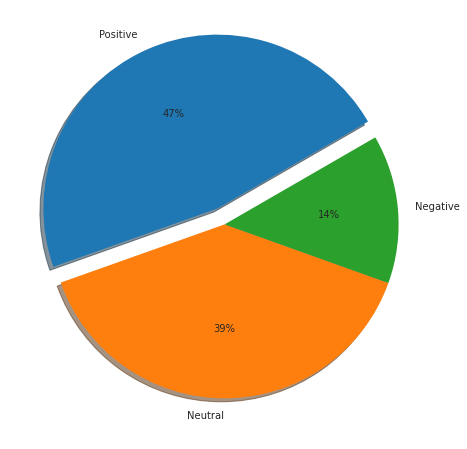

In [12]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(10,8))

values=tweet['Sentiment'].value_counts()
label=['Positive','Neutral','Negative']
explode=[0.1,0,0]

plt.pie(values,labels=label,explode=explode,autopct='%.0f%%',shadow=True,startangle=30)
plt.show()

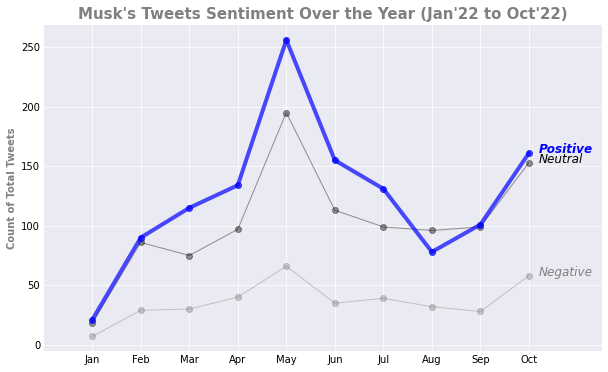

In [13]:
positive=[]
neutral=[]
negative=[]

for i in tweet['Month'].unique():
    
    pos=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Positive'),'Sentiment'].count()
    positive.append(pos)
    
    neu=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Neutral'),'Sentiment'].count()
    neutral.append(neu)
    
    neg=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Negative'),'Sentiment'].count()
    negative.append(neg)

date=tweet['Month'].unique().tolist()
month=['Oct','Sep','Aug','Jul','Jun','May','Apr','Mar','Feb','Jan']

plt.style.use('seaborn-darkgrid')

plt.figure(figsize=(10,6))

plt.plot(date,neutral,marker='o',color='black',linewidth=1, alpha=0.4)
plt.plot(date,negative,marker='o',color='grey',linewidth=1, alpha=0.4)
plt.plot(date,positive,marker='o',color='blue',linewidth=4, alpha=0.7)

plt.xlim(0,11.5)

plt.text(10.2,neutral[0],'Neutral',horizontalalignment='left',color='black',fontsize='large',fontstyle='italic',fontweight='regular')
plt.text(10.2,negative[0],'Negative',horizontalalignment='left',color='grey',fontsize='large',fontstyle='italic',fontweight='regular')
plt.text(10.2,positive[0],'Positive',horizontalalignment='left',color='blue',fontsize='large',fontstyle='italic',fontweight='semibold')

plt.xticks(date,labels=month,color='black',fontsize='medium',fontweight='medium')
plt.yticks(color='black',fontsize='medium',fontweight='medium')

plt.title("Musk's Tweets Sentiment Over the Year (Jan'22 to Oct'22)",loc='center',color='grey',fontsize=15,fontweight='semibold')
plt.ylabel("Count of Total Tweets",color='grey',fontsize=10,fontweight='semibold')
#plt.savefig('tweet over the time.png')
plt.show()

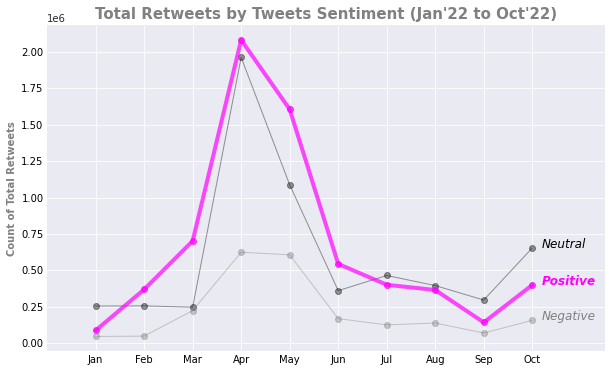

In [14]:
positive=[]
neutral=[]
negative=[]

for i in tweet['Month'].unique():
    
    pos=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Positive'),'Retweets'].sum()
    positive.append(pos)
    
    neu=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Neutral'),'Retweets'].sum()
    neutral.append(neu)
    
    neg=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Negative'),'Retweets'].sum()
    negative.append(neg)

date=tweet['Month'].unique().tolist()
month=['Oct','Sep','Aug','Jul','Jun','May','Apr','Mar','Feb','Jan']

plt.style.use('seaborn-darkgrid')

plt.figure(figsize=(10,6))

plt.plot(date,neutral,marker='o',color='black',linewidth=1, alpha=0.4)
plt.plot(date,negative,marker='o',color='grey',linewidth=1, alpha=0.4)
plt.plot(date,positive,marker='o',color='magenta',linewidth=4, alpha=0.7)

plt.xlim(0,11.5)

plt.text(10.2,neutral[0],'Neutral',horizontalalignment='left',color='black',fontsize='large',fontstyle='italic',fontweight='regular')
plt.text(10.2,negative[0],'Negative',horizontalalignment='left',color='grey',fontsize='large',fontstyle='italic',fontweight='regular')
plt.text(10.2,positive[0],'Positive',horizontalalignment='left',color='magenta',fontsize='large',fontstyle='italic',fontweight='semibold')

plt.xticks(date,labels=month,color='black',fontsize='medium',fontweight='medium')
plt.yticks(color='black',fontsize='medium',fontweight='medium')

plt.title("Total Retweets by Tweets Sentiment (Jan'22 to Oct'22)",loc='center',color='grey',fontsize=15,fontweight='semibold')
plt.ylabel("Count of Total Retweets",color='grey',fontsize=10,fontweight='semibold')
#plt.savefig('retweets by sentiment.png')
plt.show()

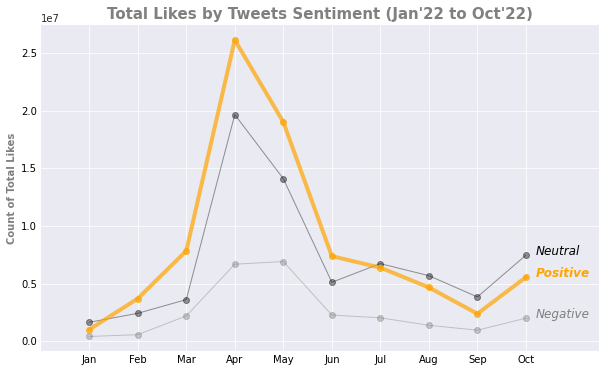

In [15]:
positive=[]
neutral=[]
negative=[]

for i in tweet['Month'].unique():
    
    pos=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Positive'),'Likes'].sum()
    positive.append(pos)
    
    neu=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Neutral'),'Likes'].sum()
    neutral.append(neu)
    
    neg=tweet.loc[(tweet['Month']==i) & (tweet['Sentiment']=='Negative'),'Likes'].sum()
    negative.append(neg)

date=tweet['Month'].unique().tolist()
month=['Oct','Sep','Aug','Jul','Jun','May','Apr','Mar','Feb','Jan']

plt.style.use('seaborn-darkgrid')

plt.figure(figsize=(10,6))

plt.plot(date,neutral,marker='o',color='black',linewidth=1, alpha=0.4)
plt.plot(date,negative,marker='o',color='grey',linewidth=1, alpha=0.4)
plt.plot(date,positive,marker='o',color='orange',linewidth=4, alpha=0.7)

plt.xlim(0,11.5)

plt.text(10.2,neutral[0],'Neutral',horizontalalignment='left',color='black',fontsize='large',fontstyle='italic',fontweight='regular')
plt.text(10.2,negative[0],'Negative',horizontalalignment='left',color='grey',fontsize='large',fontstyle='italic',fontweight='regular')
plt.text(10.2,positive[0],'Positive',horizontalalignment='left',color='orange',fontsize='large',fontstyle='italic',fontweight='semibold')

plt.xticks(date,labels=month,color='black',fontsize='medium',fontweight='medium')
plt.yticks(color='black',fontsize='medium',fontweight='medium')

plt.title("Total Likes by Tweets Sentiment (Jan'22 to Oct'22)",loc='center',color='grey',fontsize=15,fontweight='semibold')
plt.ylabel("Count of Total Likes",color='grey',fontsize=10,fontweight='semibold')
#plt.savefig('likes by sentiment.png')
plt.show()